<a href="https://colab.research.google.com/github/ZhaoQii/IST597/blob/main/IST597_HW4_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import os
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

#np.random.seed(1234)
#tf.random.set_seed(1234)

In [16]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data() # Load MNIST or FMNIST
assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

# Split train dataset into train and validation
X_val = X_train[50000:60000]
X_train = X_train[0:50000]
y_val = y_train[50000:60000]
y_train = y_train[0:50000]

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example is", str(X_train.shape[1]), "by", str(X_train.shape[2]))

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example is", str(X_val.shape[1]), "by", str(X_val.shape[2]))

X_train = X_train.reshape(50000, 28*28)
X_val = X_val.reshape(10000, 28*28)
X_test = X_test.reshape(10000, 28*28)

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example has", str(X_train.shape[1]), "features")

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example has", str(X_val.shape[1]), "features")

# Split dataset into batches
#train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16)
#test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)

size of training set is 50000 samples
every train example is 28 by 28
size of validation set is 10000 samples
every validation example is 28 by 28
size of training set is 50000 samples
every train example has 784 features
size of validation set is 10000 samples
every validation example has 784 features


In [17]:
#Normalize Data

X_train = X_train/255
X_val = X_val/255
X_test = X_test/255
# X_train[0]
np.max(X_train)

1.0

In [18]:
size_input = X_train.shape[1]
size_hidden1 = 128
size_hidden2 = 128
size_hidden3 = 128
size_output = 10
batch_size = 64

number_of_train_examples = X_train.shape[0]
number_of_test_examples = X_test.shape[0]

y_train = tf.keras.utils.to_categorical(y_train, num_classes=10) # Other function is tf.one_hot(y_train,depth=10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
print(tf.shape(y_val))

tf.Tensor([10000    10], shape=(2,), dtype=int32)


In [19]:
# Define class to build mlp model
class MLP_NB(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, BN_type, epsilon = 1e-3, device = None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    batch_size
    BN_type: 'before' for BN after pre-activation, 'after' for BN after post-activation
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.BN_type, self.epsilon, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, BN_type, epsilon, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    # Initialize biases for BN
    self.scale1 = tf.Variable(tf.ones([self.size_hidden1]))
    self.bias1 = tf.Variable(tf.zeros([self.size_hidden1]))
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    # Initialize biases for BN
    self.scale2 = tf.Variable(tf.ones([self.size_hidden2]))
    self.bias2 = tf.Variable(tf.zeros([self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    # Initialize biases for BN
    self.scale3 = tf.Variable(tf.ones([self.size_hidden3]))
    self.bias3 = tf.Variable(tf.zeros([self.size_hidden3]))

     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    # Initialize biases for BN
    self.scale4 = tf.Variable(tf.ones([self.size_output]))
    self.bias4 = tf.Variable(tf.zeros([self.size_output]))
    
    # Define variables to be updated during backpropagation
    if self.BN_type == 'before':
      # for before, then no need to do pre BN bias since it will be deleted by averaging anyway, so don't update b's for this case
      # however, should include b4 if the final output layer does not involve the BN
      self.variables = [self.W1, self.W2, self.W3, self.W4, self.b4,
                        self.scale1, self.scale2, self.scale3, #, self.scale4,
                        self.bias1, self.bias2, self.bias3]#, self.bias4]
    else:
      self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4,
                        self.scale1, self.scale2, self.scale3, #, self.scale4,
                        self.bias1, self.bias2, self.bias3]#, self.bias4]

 def forward(self, X, training, mean1 = None, var1 = None, mean2 = None, var2 = None, mean3 = None, var3 = None):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        if self.BN_type == 'before':
          self.y = self.compute_output_before(X, training, mean1, var1, mean2, var2, mean3, var3)
        else:
          self.y = self.compute_output_after(X, training, mean1, var1, mean2, var2, mean3, var3)
    else:
      if self.BN_type == 'before':
        self.y = self.compute_output_before(X, training, mean1, var1, mean2, var2, mean3, var3)
      else:
        self.y = self.compute_output_after(X, training, mean1, var1, mean2, var2, mean3, var3)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x

 def backward(self, X_train, y_train, opti, training, mean1 = None, var1 = None, mean2 = None, var2 = None, mean3 = None, var3 = None):
    """
    backward pass
    """
    optimizer = opti
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train, training, mean1 = None, var1 = None, mean2 = None, var2 = None, mean3 = None, var3 = None)
      current_loss = self.loss(predicted, y_train)
        
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
  
 def layer_mean_var(self, all_X):
    all_X_tf = tf.cast(all_X, dtype = tf.float32)
    if self.BN_type == 'before':
      z1_all = tf.matmul(all_X_tf, self.W1) + self.b1
      mean1, var1 = tf.nn.moments(z1_all, [0])
      z1_BN_all = (z1_all - mean1) / tf.sqrt(var1 + self.epsilon)
      BN1_all = self.scale1 * z1_BN_all + self.bias1
      h1_all = tf.nn.relu(BN1_all)
      
      z2_all = tf.matmul(h1_all, self.W2) + self.b2
      mean2, var2 = tf.nn.moments(z2_all, [0])
      z2_BN_all = (z2_all - mean2) / tf.sqrt(var2 + self.epsilon)
      BN2_all = self.scale2 * z2_BN_all + self.bias2
      h2_all = tf.nn.relu(BN2_all)
      
      z3_all = tf.matmul(h2_all, self.W3) + self.b3
      mean3, var3 = tf.nn.moments(z3_all, [0])
    else:
      z1_all = tf.matmul(all_X_tf, self.W1) + self.b1
      z1_h1_all = tf.nn.relu(z1_all)
      mean1, var1 = tf.nn.moments(z1_h1_all, [0])
      z1_BN_all = (z1_h1_all - mean1) / tf.sqrt(var1 + self.epsilon)
      h1_all = self.scale1 * z1_BN_all + self.bias1

      z2_all = tf.matmul(h1_all, self.W2) + self.b2
      z2_h2_all = tf.nn.relu(z2_all)
      mean2, var2 = tf.nn.moments(z2_h2_all, [0])
      z2_BN_all = (z2_h2_all - mean2) / tf.sqrt(var2 + self.epsilon)
      h2_all = self.scale1 * z2_BN_all + self.bias2

      z3_all = tf.matmul(h2_all, self.W3) + self.b3
      z3_h3_all = tf.nn.relu(z3_all)
      mean3, var3 = tf.nn.moments(z3_h3_all, [0])
    
    return(mean1, var1, mean2, var2, mean3, var3)

 def compute_output_before(self, X, training, mean1 = None, var1 = None, mean2 = None, var2 = None, mean3 = None, var3 = None):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X

    # Compute values in hidden layers
    if training == True:
      z1 = tf.matmul(X_tf, self.W1) + self.b1
      batch_mean1, batch_var1 = tf.nn.moments(z1, [0])
      z1_BN = (z1 - batch_mean1) / tf.sqrt(batch_var1 + self.epsilon)
      BN1 = self.scale1 * z1_BN + self.bias1
      h1 = tf.nn.relu(BN1)
      
      z2 = tf.matmul(h1, self.W2) + self.b2
      batch_mean2, batch_var2 = tf.nn.moments(z2, [0])
      z2_BN = (z2 - batch_mean2) / tf.sqrt(batch_var2 + self.epsilon)
      BN2 = self.scale2 * z2_BN + self.bias2
      h2 = tf.nn.relu(BN2)
      
      z3 = tf.matmul(h2, self.W3) + self.b3
      batch_mean3, batch_var3 = tf.nn.moments(z3, [0])
      z3_BN = (z3 - batch_mean3) / tf.sqrt(batch_var3 + self.epsilon)
      BN3 = self.scale3 * z3_BN + self.bias3
      h3 = tf.nn.relu(BN3)

    else:
      z1 = tf.matmul(X_tf, self.W1) + self.b1
      z1_BN = (z1 - mean1) / tf.sqrt(var1 + self.epsilon)
      BN1 = self.scale1 * z1_BN + self.bias1
      h1 = tf.nn.relu(BN1)
      
      z2 = tf.matmul(h1, self.W2) + self.b2
      z2_BN = (z2 - mean2) / tf.sqrt(var2 + self.epsilon)
      BN2 = self.scale2 * z2_BN + self.bias2
      h2 = tf.nn.relu(BN2)
      
      z3 = tf.matmul(h2, self.W3) + self.b3
      z3_BN = (z3 - mean3) / tf.sqrt(var3 + self.epsilon)
      BN3 = self.scale3 * z3_BN + self.bias3
      h3 = tf.nn.relu(BN3)

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4

    # as no BN for output layer if BN_type == 'after'
    #batch_mean4, batch_var4 = tf.nn.moments(output, [0])
    #z4_BN = (output - batch_mean4) / tf.sqrt(batch_var4 + self.epsilon)
    #output = self.scale4 * z4_BN + self.bias4
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)

 def compute_output_after(self, X, training, mean1 = None, var1 = None, mean2 = None, var2 = None, mean3 = None, var3 = None):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    # Compute values in hidden layers

    if training == True:
    
      # Compute values in hidden layers
      z1 = tf.matmul(X_tf, self.W1) + self.b1
      z1_h1 = tf.nn.relu(z1)
      batch_mean1, batch_var1 = tf.nn.moments(z1_h1, [0])
      z1_BN = (z1_h1 - batch_mean1) / tf.sqrt(batch_var1 + self.epsilon)
      h1 = self.scale1 * z1_BN + self.bias1
      
      z2 = tf.matmul(h1, self.W2) + self.b2
      z2_h2 = tf.nn.relu(z2)
      batch_mean2, batch_var2 = tf.nn.moments(z2_h2, [0])
      z2_BN = (z2_h2 - batch_mean2) / tf.sqrt(batch_var2 + self.epsilon)
      h2 = self.scale2 * z2_BN + self.bias2
      
      z3 = tf.matmul(h2, self.W3) + self.b3
      z3_h3 = tf.nn.relu(z3)
      batch_mean3, batch_var3 = tf.nn.moments(z3_h3, [0])
      z3_BN = (z3_h3 - batch_mean3) / tf.sqrt(batch_var3 + self.epsilon)
      h3 = self.scale3 * z3_BN + self.bias3

    else:
      z1 = tf.matmul(X_tf, self.W1) + self.b1
      z1_h1 = tf.nn.relu(z1)
      z1_BN = (z1_h1 - mean1) / tf.sqrt(var1 + self.epsilon)
      h1 = self.scale1 * z1_BN + self.bias1
      
      z2 = tf.matmul(h1, self.W2) + self.b2
      z2_h2 = tf.nn.relu(z2)
      z2_BN = (z2_h2 - mean2) / tf.sqrt(var2 + self.epsilon)
      h2 = self.scale2 * z2_BN + self.bias2
      
      z3 = tf.matmul(h2, self.W3) + self.b3
      z3_h3 = tf.nn.relu(z3)
      z3_BN = (z3_h3 - mean3) / tf.sqrt(var3 + self.epsilon)
      h3 = self.scale3 * z3_BN + self.bias3

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)

#  def stderr(self,y_pred):
#     """
#      Calculate standard error
#      """
#     y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
#     std_dev = np.std(y_pred_tf) #Calculates standard deviation
#     std_err = std_dev/sqrt(len(y_pred_tf))
#     return std_err 


#  def var(self,y_pred):
#     """
#      Calculate variance 
#      """
#     y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
#     std_dev = np.std(y_pred_tf) #Calculates standard deviation
#     variance = (std_dev**2) # calculate variance
#     return variance 

## Validation


Train Accuracy: 0.8552
Number of Epoch = 1 - Average Cross Entropy:= 0.006404358520507813 

Validation Accuracy: 0.8411

Train Accuracy: 0.8807
Number of Epoch = 2 - Average Cross Entropy:= 0.005052757263183594 

Validation Accuracy: 0.8629

Train Accuracy: 0.8807
Number of Epoch = 3 - Average Cross Entropy:= 0.0048899420166015626 

Validation Accuracy: 0.8526

Train Accuracy: 0.8975
Number of Epoch = 4 - Average Cross Entropy:= 0.004215007934570312 

Validation Accuracy: 0.8661

Train Accuracy: 0.8938
Number of Epoch = 5 - Average Cross Entropy:= 0.004299261474609375 

Validation Accuracy: 0.8586

Train Accuracy: 0.9008
Number of Epoch = 6 - Average Cross Entropy:= 0.004078229370117188 

Validation Accuracy: 0.8629

Train Accuracy: 0.9243
Number of Epoch = 7 - Average Cross Entropy:= 0.0031858657836914064 

Validation Accuracy: 0.8760

Train Accuracy: 0.9064
Number of Epoch = 8 - Average Cross Entropy:= 0.003711279296875 

Validation Accuracy: 0.8572

Train Accuracy: 0.9223
Number of

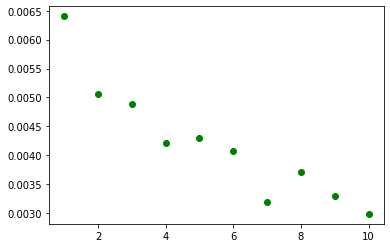

In [ ]:
###################### before
# Set number of epochs
NUM_EPOCHS = 10

# Initialize model using CPU
mlp_on_cpu = MLP_NB(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, BN_type = 'before', epsilon = 1e-3, device = 'cpu')

time_start = time.time()
opti = tf.keras.optimizers.SGD(learning_rate = 0.1)

for epoch in range(NUM_EPOCHS):
  
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(1234)).batch(batch_size)
  accuracy_z = 0.0
  cur_train_acc = 0.0
  
  # training 
  for inputs, outputs in train_ds:
    #preds = mlp_on_cpu.forward(inputs, training = True, mean1 = None, var1 = None, mean2 = None, var2 = None, mean3 = None, var3 = None)
    mlp_on_cpu.backward(inputs, outputs, opti, training = True)

  # layer means and vars given all data
  mean1, var1, mean2, var2, mean3, var3 = mlp_on_cpu.layer_mean_var(X_train)

  # training loss
  for inputs, outputs in train_ds:
    preds = mlp_on_cpu.forward(inputs, training = False, mean1 = mean1, var1 = var1, mean2 = mean2, var2 = var2, mean3 = mean3, var3 = var3)
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)

  preds = mlp_on_cpu.forward(X_train, training = False, mean1 = mean1, var1 = var1, mean2 = mean2, var2 = var2, mean3 = mean3, var3 = var3)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val, training = False, mean1 = mean1, var1 = var1, mean2 = mean2, var2 = var2, mean3 = mean3, var3 = var3)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epoch


Train Accuracy: 0.8657
Number of Epoch = 1 - Average Cross Entropy:= 0.00580166748046875 

Validation Accuracy: 0.8494

Train Accuracy: 0.8766
Number of Epoch = 2 - Average Cross Entropy:= 0.005262592163085937 

Validation Accuracy: 0.8593

Train Accuracy: 0.8782
Number of Epoch = 3 - Average Cross Entropy:= 0.0051205224609375 

Validation Accuracy: 0.8512

Train Accuracy: 0.8945
Number of Epoch = 4 - Average Cross Entropy:= 0.004328527221679687 

Validation Accuracy: 0.8711

Train Accuracy: 0.9019
Number of Epoch = 5 - Average Cross Entropy:= 0.004092961120605469 

Validation Accuracy: 0.8709

Train Accuracy: 0.8969
Number of Epoch = 6 - Average Cross Entropy:= 0.004291982421875 

Validation Accuracy: 0.8671

Train Accuracy: 0.9136
Number of Epoch = 7 - Average Cross Entropy:= 0.0036248968505859375 

Validation Accuracy: 0.8767

Train Accuracy: 0.9032
Number of Epoch = 8 - Average Cross Entropy:= 0.003959103393554687 

Validation Accuracy: 0.8633

Train Accuracy: 0.9159
Number of Epo

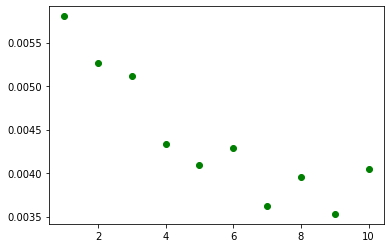

In [ ]:
########################## after 
# Set number of epochs
NUM_EPOCHS = 10

# Initialize model using CPU
mlp_on_cpu = MLP_NB(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, BN_type = 'after', epsilon = 1e-3, device = 'cpu')

time_start = time.time()
opti = tf.keras.optimizers.SGD(learning_rate = 0.1)

for epoch in range(NUM_EPOCHS):
  
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(1234)).batch(batch_size)
  accuracy_z = 0.0
  cur_train_acc = 0.0
  
  # training 
  for inputs, outputs in train_ds:
    #preds = mlp_on_cpu.forward(inputs, training = True, mean1 = None, var1 = None, mean2 = None, var2 = None, mean3 = None, var3 = None)
    mlp_on_cpu.backward(inputs, outputs, opti, training = True)

  # layer means and vars given all data
  mean1, var1, mean2, var2, mean3, var3 = mlp_on_cpu.layer_mean_var(X_train)

  # training loss
  for inputs, outputs in train_ds:
    preds = mlp_on_cpu.forward(inputs, training = False, mean1 = mean1, var1 = var1, mean2 = mean2, var2 = var2, mean3 = mean3, var3 = var3)
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)

  preds = mlp_on_cpu.forward(X_train, training = False, mean1 = mean1, var1 = var1, mean2 = mean2, var2 = var2, mean3 = mean3, var3 = var3)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val, training = False, mean1 = mean1, var1 = var1, mean2 = mean2, var2 = var2, mean3 = mean3, var3 = var3)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

## Performance

In [20]:
num_trials = 3

test_accuracy = np.zeros([num_trials, 2]) # 0 for before 1 for after
used_time = np.zeros([num_trials, 2])

# Set number of epochs
NUM_EPOCHS = 10

In [21]:
for t in range(num_trials):
  # Initialize model using CPU
  mlp_on_cpu = MLP_NB(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, BN_type = 'before', epsilon = 1e-3, device = 'cpu')

  time_start = time.time()
  opti = tf.keras.optimizers.SGD(learning_rate = 0.1)

  for epoch in range(NUM_EPOCHS):
    print(t, epoch)
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(1178)).batch(batch_size)
    
    # training 
    for inputs, outputs in train_ds:
      #preds = mlp_on_cpu.forward(inputs, training = True, mean1 = None, var1 = None, mean2 = None, var2 = None, mean3 = None, var3 = None)
      mlp_on_cpu.backward(inputs, outputs, opti, training = True)

  time_taken = time.time() - time_start
      
  used_time[t, 0] = time_taken
      
  # layer means and vars given all data
  mean1, var1, mean2, var2, mean3, var3 = mlp_on_cpu.layer_mean_var(X_train)

  # test sample
  preds = mlp_on_cpu.forward(X_test, training = False, mean1 = mean1, var1 = var1, mean2 = mean2, var2 = var2, mean3 = mean3, var3 = var3)
  preds = tf.nn.softmax(preds)
  correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(y_test, 1))
  test_accuracy[t, 0] = tf.reduce_mean(tf.cast(correct_preds, 'float'))

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9


In [24]:
for t in range(num_trials):
  # Initialize model using CPU
  mlp_on_cpu = MLP_NB(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, BN_type = 'after', epsilon = 1e-3, device = 'cpu')

  time_start = time.time()
  opti = tf.keras.optimizers.SGD(learning_rate = 0.1)

  for epoch in range(NUM_EPOCHS):
    print(t, epoch)
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(178)).batch(batch_size)
    
    # training 
    for inputs, outputs in train_ds:
      #preds = mlp_on_cpu.forward(inputs, training = True, mean1 = None, var1 = None, mean2 = None, var2 = None, mean3 = None, var3 = None)
      mlp_on_cpu.backward(inputs, outputs, opti, training = True)

  time_taken = time.time() - time_start
      
  used_time[t, 1] = time_taken
      
  # layer means and vars given all data
  mean1, var1, mean2, var2, mean3, var3 = mlp_on_cpu.layer_mean_var(X_train)

  # test sample
  preds = mlp_on_cpu.forward(X_test, training = False, mean1 = mean1, var1 = var1, mean2 = mean2, var2 = var2, mean3 = mean3, var3 = var3)
  preds = tf.nn.softmax(preds)
  correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(y_test, 1))
  test_accuracy[t, 1] = tf.reduce_mean(tf.cast(correct_preds, 'float'))

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9


In [25]:
used_time

array([[174.80074906, 191.88938785],
       [191.17664671, 177.94594336],
       [161.02315879, 187.18760562]])

In [26]:
test_accuracy

array([[0.85549998, 0.86369997],
       [0.86690003, 0.87589997],
       [0.85439998, 0.87180001]])